# Core Imports and Setup

In [1]:
import os
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import logging
# logging.getLogger("openff.toolkit").setLevel(logging.ERROR)
# logging.basicConfig(level=logging.DEBUG)

import json
from openff import toolkit, evaluator

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage
import pubchempy
from PIL import Image, ImageDraw, ImageFont
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs

In [ ]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase
from openff.evaluator.datasets.thermoml import thermoml_property
from openff.evaluator import properties
from openff.units import unit
from openff.evaluator.datasets.thermoml import ThermoMLDataSet

# 0) Registering Custom ThermoML Property

In [3]:

@thermoml_property("Osmotic coefficient", supported_phases=PropertyPhase.Liquid | PropertyPhase.Gas)
class OsmoticCoefficient(PhysicalProperty):
    """A class representation of a osmotic coeff property"""

    @classmethod
    def default_unit(cls):
        return unit.dimensionless
    
setattr(properties, OsmoticCoefficient.__name__, OsmoticCoefficient)

In [4]:
ThermoMLDataSet.registered_properties['Osmotic coefficient'].conversion_function

functools.partial(<function _default_mapping at 0x7f9466cf6d40>, <class '__main__.OsmoticCoefficient'>)

# 1) - Loading ThermoML Data Sets

## Extracting data from ThermoML

In [5]:
from openff.evaluator.datasets.thermoml import ThermoMLDataSet

CACHED_PROP_PATH = Path('osmotic_data.csv')

if CACHED_PROP_PATH.exists():
    prop_df = pd.read_csv(CACHED_PROP_PATH, index_col=0)
    # delete rows with underfined thermo params to avoid pesky indexing errors
    prop_df = prop_df.dropna(subset=['Temperature (K)'])
    prop_df = prop_df.dropna(subset=['Pressure (kPa)'])
    data_set = ThermoMLDataSet.from_pandas(prop_df)
else:
    with open('sorted_dois.json') as f:
        doi_dat = json.load(f)
        data_set = ThermoMLDataSet.from_doi(*doi_dat['working'])

    prop_df = data_set.to_pandas()
    with CACHED_PROP_PATH.open('w') as file:
        prop_df.to_csv(CACHED_PROP_PATH)


In [6]:
prop_df

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,...,Exact Amount 2,Component 3,Role 3,Mole Fraction 3,Exact Amount 3,OsmoticCoefficient Value (),OsmoticCoefficient Uncertainty (),Density Value (g / ml),Density Uncertainty (g / ml),Source
0,cddc9485a39c414a90b3a1b4e4219af0,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.008848,NaN,[Cl-].[Na+],...,NaN,O,Solvent,0.982303,NaN,0.910,0.0055,NaN,NaN,10.1016/j.jct.2013.08.018
1,7a612b0d9b7649b5917ed0a414946bb0,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.017541,NaN,[Cl-].[Na+],...,NaN,O,Solvent,0.973688,NaN,0.906,0.0055,NaN,NaN,10.1016/j.jct.2013.08.018
2,50bb0c2a55f847c99d3ece35f41de236,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.026083,NaN,[Cl-].[Na+],...,NaN,O,Solvent,0.965222,NaN,0.897,0.0055,NaN,NaN,10.1016/j.jct.2013.08.018
3,a59ee6df2abd46c1b290634a0ab20866,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.034478,NaN,[Cl-].[Na+],...,NaN,O,Solvent,0.956903,NaN,0.891,0.0055,NaN,NaN,10.1016/j.jct.2013.08.018
4,790f5a6318a14d109c5ae0fa8d48ce6b,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.003527,NaN,[Cl-].[Na+],...,NaN,O,Solvent,0.978839,NaN,0.949,0.0050,NaN,NaN,10.1016/j.jct.2013.08.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5309,61b6618b9cf14bb4b834bdbc8781b778,298.15,100.0,Liquid,2,N[C@@H](CO)C(=O)O,Solvent,0.050150,NaN,O,...,NaN,NaN,NaN,NaN,NaN,0.855,0.0055,NaN,NaN,10.1016/j.jct.2014.11.014
5310,f0c41da8c27b4c8fb3dee9d80d6b92e7,298.15,100.0,Liquid,2,N[C@@H](CO)C(=O)O,Solvent,0.053226,NaN,O,...,NaN,NaN,NaN,NaN,NaN,0.875,0.0055,NaN,NaN,10.1016/j.jct.2014.11.014
5311,2aa873ad04d0463c94e30ebbc67b768a,298.15,100.0,Liquid,2,N[C@@H](CO)C(=O)O,Solvent,0.054518,NaN,O,...,NaN,NaN,NaN,NaN,NaN,0.872,0.0055,NaN,NaN,10.1016/j.jct.2014.11.014
5312,1616e00c3f9d408e839e3103487605f9,298.15,100.0,Liquid,2,N[C@@H](CO)C(=O)O,Solvent,0.058436,NaN,O,...,NaN,NaN,NaN,NaN,NaN,0.861,0.0055,NaN,NaN,10.1016/j.jct.2014.11.014


## Filtering data set

In [7]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByTemperature, FilterByTemperatureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByPressure, FilterByPressureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

In [8]:
# Property
# schema = FilterByPropertyTypesSchema(property_types=["Density"])
schema = FilterByPropertyTypesSchema(property_types=["OsmoticCoefficient"], strict=False)

data_set_osmotic = FilterByPropertyTypes.apply(data_set, schema)

print(len(data_set_osmotic))

2784


In [9]:
subs=list(set(data_set_osmotic.substances))
smiles_list=[]
comps=[]

for i in subs:
    if len(i.components) == 3:
        comps.append(i.components[0].smiles)
        comps.append(i.components[1].smiles)
        comps.append(i.components[2].smiles)
    elif len(i.components) == 2:
        comps.append(i.components[0].smiles)
        comps.append(i.components[1].smiles)
    elif len(i.components) == 1:
        comps.append(i.components[0].smiles)

print(len(comps))

comps.remove('O')

[smiles_list.append(o) for o in set(comps)]

print(len(smiles_list))

3481
61


In [10]:
df_osmotic=data_set_osmotic.to_pandas()

In [11]:
df_osmotic.head()

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,Component 3,Role 3,Mole Fraction 3,Exact Amount 3,OsmoticCoefficient Value (),OsmoticCoefficient Uncertainty (),Source
0,cddc9485a39c414a90b3a1b4e4219af0,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.008848,None,[Cl-].[Na+],Solvent,0.008848,NaN,O,Solvent,0.982303,NaN,0.910,0.0055,10.1016/j.jct.2013.08.018
1,7a612b0d9b7649b5917ed0a414946bb0,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.017541,None,[Cl-].[Na+],Solvent,0.008771,NaN,O,Solvent,0.973688,NaN,0.906,0.0055,10.1016/j.jct.2013.08.018
2,50bb0c2a55f847c99d3ece35f41de236,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.026083,None,[Cl-].[Na+],Solvent,0.008694,NaN,O,Solvent,0.965222,NaN,0.897,0.0055,10.1016/j.jct.2013.08.018
3,a59ee6df2abd46c1b290634a0ab20866,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.034478,None,[Cl-].[Na+],Solvent,0.008619,NaN,O,Solvent,0.956903,NaN,0.891,0.0055,10.1016/j.jct.2013.08.018
4,790f5a6318a14d109c5ae0fa8d48ce6b,298.15,101.0,Liquid,3,NCC(=O)O,Solvent,0.003527,None,[Cl-].[Na+],Solvent,0.017634,NaN,O,Solvent,0.978839,NaN,0.949,0.0050,10.1016/j.jct.2013.08.018


In [12]:
df_osmotic.to_csv('osmotic_database.csv',index=False)

In [13]:
df_osmotic.columns.to_list()

['Id',
 'Temperature (K)',
 'Pressure (kPa)',
 'Phase',
 'N Components',
 'Component 1',
 'Role 1',
 'Mole Fraction 1',
 'Exact Amount 1',
 'Component 2',
 'Role 2',
 'Mole Fraction 2',
 'Exact Amount 2',
 'Component 3',
 'Role 3',
 'Mole Fraction 3',
 'Exact Amount 3',
 'OsmoticCoefficient Value ()',
 'OsmoticCoefficient Uncertainty ()',
 'Source']

In [14]:
df_osmotic[['N Components','Component 1']]

,N Components,Component 1
0,3,NCC(=O)O
1,3,NCC(=O)O
2,3,NCC(=O)O
3,3,NCC(=O)O
4,3,NCC(=O)O
...,...,...
2779,2,N[C@@H](CO)C(=O)O
2780,2,N[C@@H](CO)C(=O)O
2781,2,N[C@@H](CO)C(=O)O
2782,2,N[C@@H](CO)C(=O)O


In [15]:
def get_figures(smiles_list):
    func_group_mols=[]
    matchlegend=[]
    for m in set(smiles_list):
        if m != 'O':
            compounds=pubchempy.get_compounds(m, namespace='smiles')
            match = compounds[0]
            match_name=str(match.iupac_name)
            matchlegend.append(match_name)
            mol=Chem.MolFromSmiles(m)
            func_group_mols.append(mol)
    init_fig=MolsToGridImage(mols=func_group_mols, legends=matchlegend, molsPerRow=10, returnPNG=False)
    return init_fig


In [16]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pubchempy as pcp

def smiles_to_iupac(df, smiles_column, new_column_name='IUPAC'):
    # Initialize an empty list to store the IUPAC names
    iupac_names = []

    # Iterate over each SMILES string in the specified column
    for smiles in df[smiles_column]:
        try:
            # Convert the SMILES string to a molecule object using RDKit
            mol = Chem.MolFromSmiles(smiles)
            
            if mol: 
                # Get the molecular formula for reference (not necessary)
                formula = rdMolDescriptors.CalcMolFormula(mol)
                
                # Use PubChemPy to search for the IUPAC name by molecular formula or SMILES
                compounds = pcp.get_compounds(smiles, 'smiles')
                
                if compounds:
                    iupac_name = compounds[0].iupac_name  # Get the IUPAC name from the first match
                else:
                    iupac_name = None
            else:
                iupac_name = None
        except Exception as e:
            iupac_name = None
        
        # Append the IUPAC name (or None) to the list
        iupac_names.append(iupac_name)

    # Find the position of the reference column (smiles_column)
    col_position = df.columns.get_loc(smiles_column)
    
    # Insert the new column with IUPAC names right next to the SMILES column
    df.insert(col_position + 1, new_column_name, iupac_names)

    return df

# Example usage:
# df = pd.DataFrame({'SMILES': ['CCO', 'C1=CC=CC=C1']})
# df = smiles_to_iupac(df, 'SMILES')
# print(df)



In [17]:
# df_osmotic_smiles=[i for i in df_osmotic['Component 1']]
df_osmotic_new=smiles_to_iupac(df_osmotic, 'Component 1', new_column_name='IUPAC1')

KeyboardInterrupt: 

In [17]:
df_osmotic_new2=smiles_to_iupac(df_osmotic_new, 'Component 2', new_column_name='IUPAC2')

In [18]:
df_osmotic_new3=smiles_to_iupac(df_osmotic_new2, 'Component 3', new_column_name='IUPAC3')

In [19]:
df_osmotic_new3.head()

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,IUPAC1,Role 1,Mole Fraction 1,Exact Amount 1,...,Mole Fraction 2,Exact Amount 2,Component 3,IUPAC3,Role 3,Mole Fraction 3,Exact Amount 3,OsmoticCoefficient Value (),OsmoticCoefficient Uncertainty (),Source
0,cddc9485a39c414a90b3a1b4e4219af0,298.15,101.0,Liquid,3,NCC(=O)O,2-aminoacetic acid,Solvent,0.008848,None,...,0.008848,NaN,O,oxidane,Solvent,0.982303,NaN,0.910,0.0055,10.1016/j.jct.2013.08.018
1,7a612b0d9b7649b5917ed0a414946bb0,298.15,101.0,Liquid,3,NCC(=O)O,2-aminoacetic acid,Solvent,0.017541,None,...,0.008771,NaN,O,oxidane,Solvent,0.973688,NaN,0.906,0.0055,10.1016/j.jct.2013.08.018
2,50bb0c2a55f847c99d3ece35f41de236,298.15,101.0,Liquid,3,NCC(=O)O,2-aminoacetic acid,Solvent,0.026083,None,...,0.008694,NaN,O,oxidane,Solvent,0.965222,NaN,0.897,0.0055,10.1016/j.jct.2013.08.018
3,a59ee6df2abd46c1b290634a0ab20866,298.15,101.0,Liquid,3,NCC(=O)O,2-aminoacetic acid,Solvent,0.034478,None,...,0.008619,NaN,O,oxidane,Solvent,0.956903,NaN,0.891,0.0055,10.1016/j.jct.2013.08.018
4,790f5a6318a14d109c5ae0fa8d48ce6b,298.15,101.0,Liquid,3,NCC(=O)O,2-aminoacetic acid,Solvent,0.003527,None,...,0.017634,NaN,O,oxidane,Solvent,0.978839,NaN,0.949,0.0050,10.1016/j.jct.2013.08.018


In [20]:
iupacs=[i for i in set(df_osmotic_new3['IUPAC1'])]

In [21]:
df_osmotic_new3[
['Id',
 'Temperature (K)',
 'Pressure (kPa)',
 'N Components',
 'Component 1',
 'IUPAC1',
 'Role 1',
 'Mole Fraction 1',
 'Component 2',
 'IUPAC2',
 'Role 2',
 'Mole Fraction 2',
 'Component 3',
 'IUPAC3',
 'Role 3',
 'Mole Fraction 3',
 'OsmoticCoefficient Value ()',
 'OsmoticCoefficient Uncertainty ()',
 'Source']
].to_csv('osmotic_database_iupac.csv', index=False)

In [22]:
# df_select=df_osmotic[(df_osmotic['Temperature (K)'] > 293.0) & (df_osmotic['Temperature (K)'] < 300.0) & (df_osmotic['Pressure (kPa)'] == 101 ) & (df_osmotic['N Components'] == 2) & (df_osmotic['Component 2'] == 'O')]
df_select=df_osmotic[(df_osmotic['Temperature (K)'] > 293.0) & (df_osmotic['Temperature (K)'] < 300.0) & (df_osmotic['Pressure (kPa)'] == 101 ) & (df_osmotic['N Components'] == 2)]

In [23]:
print(df_select)

                                    Id  Temperature (K)  Pressure (kPa)  \
8     1690923bb58e473aa7ae28cca55e9516           298.15           101.0   
21    6c8b1a072a12461bb44dc735b30d12ed           298.15           101.0   
35    36504db66e8d417094240caa9ff34414           298.15           101.0   
44    73a36cdb4d8c494e97c2b2ca7442b953           298.15           101.0   
48    6f51277e358c474f98026d7d8a2d062d           298.15           101.0   
...                                ...              ...             ...   
2647  73fb5f74bbdd4504ae9da986ce050e69           298.15           101.0   
2648  6bbbb54020f94e03b2c4112d55c74954           298.15           101.0   
2649  560e52bc823b4253a40bf828a0955958           298.15           101.0   
2650  bc436df25a3a4043a3531358ee50d868           298.15           101.0   
2651  22fe6dc3b25a428584fe3da5c5a8478d           298.15           101.0   

       Phase  N Components  Component 1              IUPAC1   Role 1  \
8     Liquid             2 

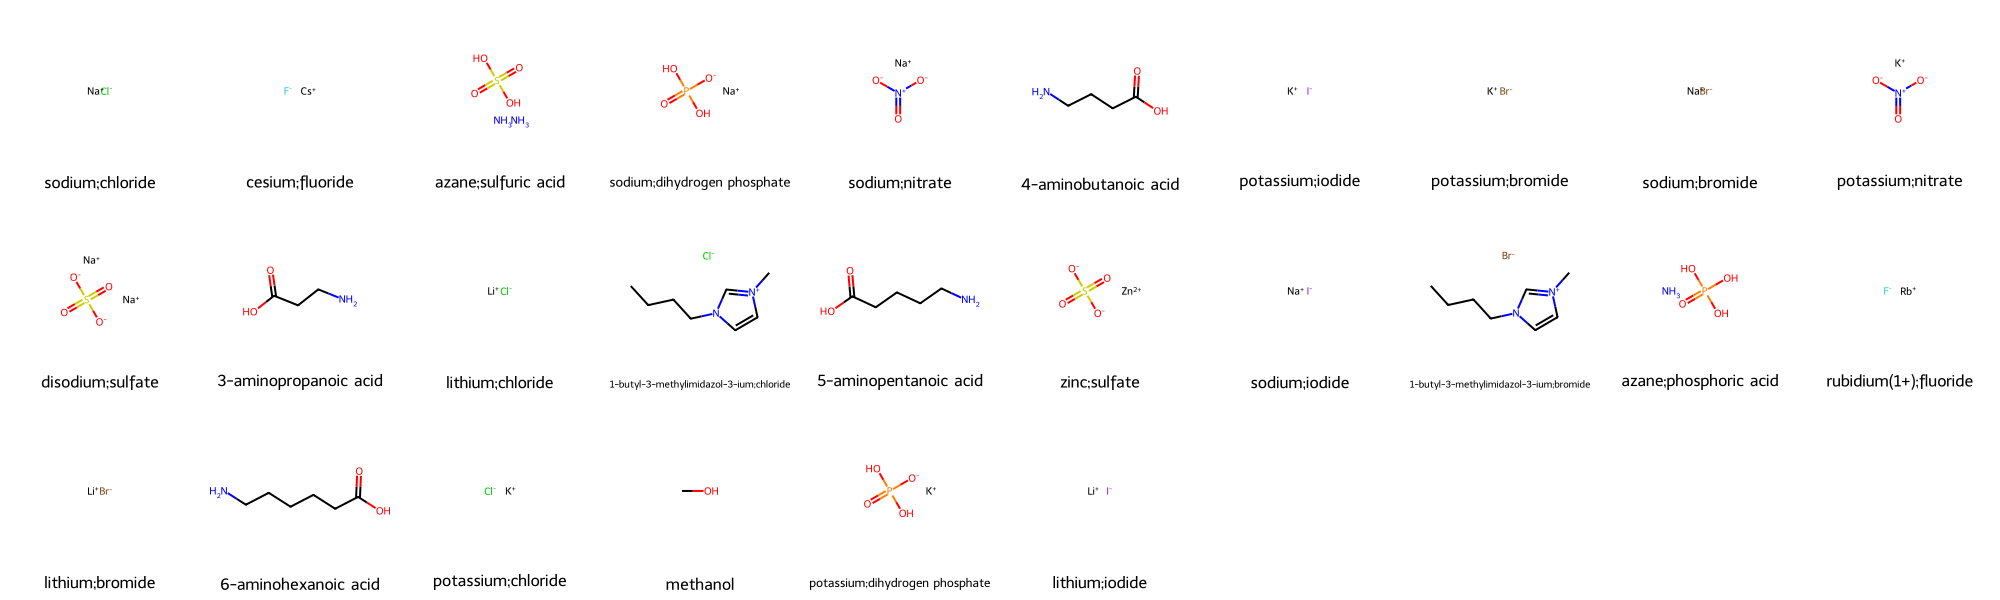

In [24]:
df_select_smiles1=df_select['Component 1']
df_select_smiles2=df_select['Component 2']
df_select_smiles3=df_select['Component 3']

get_figures(df_select_smiles1)

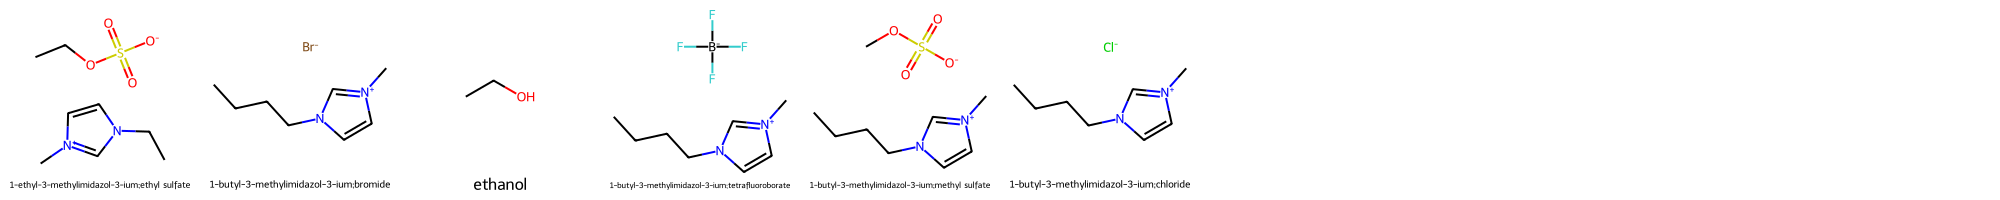

In [25]:
get_figures(df_select_smiles2)

In [26]:
df_select[
['Id',
 'Temperature (K)',
 'Pressure (kPa)',
 'N Components',
 'Component 1',
 'Role 1',
 'Mole Fraction 1',
 'Component 2',
 'Role 2',
 'Mole Fraction 2',
 'OsmoticCoefficient Value ()',
 'OsmoticCoefficient Uncertainty ()',
 'Source']
].to_csv('osm_selection.csv', index=False)

In [27]:
df_select_ions=df_select[(df_select['Component 1'].str.contains('+', regex=False)) | (df_select['Component 1'].str.contains('-', regex=False))]
df_select_nonions=df_select[~(df_select['Component 1'].str.contains('+', regex=False)) | ~(df_select['Component 1'].str.contains('-', regex=False))]

In [28]:
df_select_ions.shape

(366, 23)

In [29]:
df_select_nonions.shape

(169, 23)

In [30]:
df_select_ions[
['Id',
 'Temperature (K)',
 'Pressure (kPa)',
 'N Components',
 'Component 1',
 'Role 1',
 'Mole Fraction 1',
 'Component 2',
 'Role 2',
 'Mole Fraction 2',
 'OsmoticCoefficient Value ()',
 'OsmoticCoefficient Uncertainty ()',
 'Source']
].to_csv('osm_selection_ions.csv', index=False)

In [31]:
df_select_nonions[
['Id',
 'Temperature (K)',
 'Pressure (kPa)',
 'N Components',
 'Component 1',
 'Role 1',
 'Mole Fraction 1',
 'Component 2',
 'Role 2',
 'Mole Fraction 2',
 'OsmoticCoefficient Value ()',
 'OsmoticCoefficient Uncertainty ()',
 'Source']
].to_csv('osm_selection_nonions.csv', index=False)

In [32]:
# df_select.to_csv('osm_selection.csv', index=False)

In [33]:
# pandas_data_set = data_set.to_pandas()
# pandas_data_set[
#     [
#         "Temperature (K)",
#         "Pressure (kPa)",
#         "Component 1",
#         "OsmoticCoefficient Value ()",
#         "Source",
#     ]
# ].head()

In [34]:

# # Property
# data_set = FilterByPropertyTypes.apply(
#     data_set, FilterByPropertyTypesSchema(property_types=["Density"])
# )

# # Temperature
# data_set = FilterByTemperature.apply(
#     data_set, FilterByTemperatureSchema(minimum_temperature=298.0, maximum_temperature=330.0)
# )

# # Pressure
# data_set = FilterByPressure.apply(
#     data_set, FilterByPressureSchema(minimum_pressure=100.0, maximum_pressure=105.426)
# )

# # Solvent
# data_set = FilterBySmiles.apply(
#     data_set, FilterBySmilesSchema(smiles_to_include=["CCO", "CC(C)O"])
# )

# print(len(data_set))